In [10]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
import utils.dsp
import utils.phantom
import utils.opt
from recon.TV_FISTA import *

# get device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

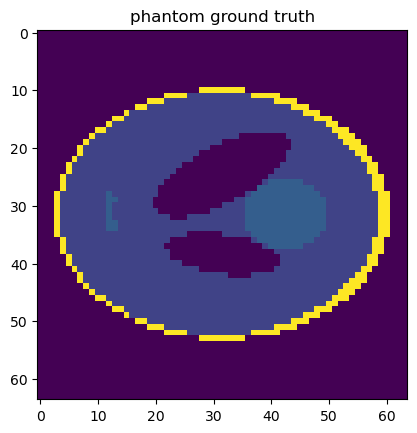

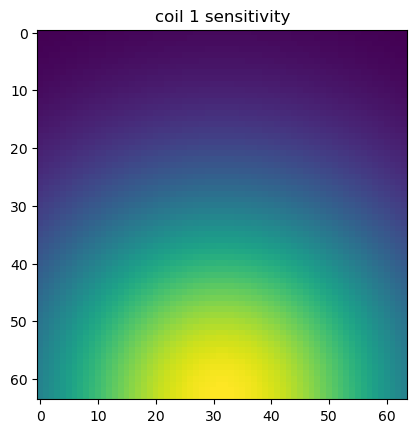

In [35]:
# create a simple shepp logan phantom and plot
N = (64,64,1)
image = utils.phantom.phantomNd(N).squeeze().to(device)
plt.figure(0)
plt.imshow(np.absolute(image.cpu().numpy()))
plt.title('phantom ground truth')
plt.show()

# simulate coils sensitivity maps and plot
smaps = utils.phantom.simsmaps(N).squeeze().to(device)
plt.figure(1)
plt.imshow(np.absolute(smaps[1].cpu().numpy()))
plt.title('coil 1 sensitivity')
plt.show()

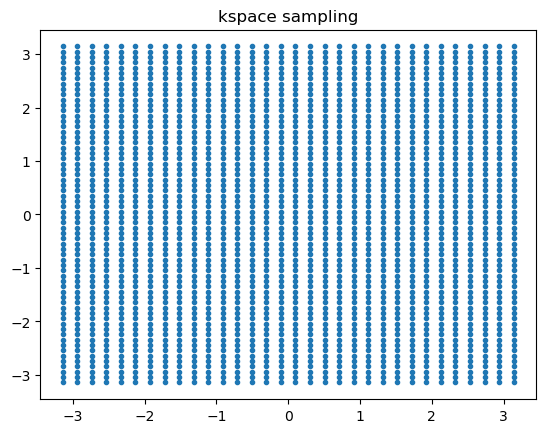

In [23]:
radial = 1
if radial:
    # create a 2d golden angle radial k-space trajectory and plot it
    spokelength = image.shape[-1] * 2
    nspokes = 200
    ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
    kx = np.zeros(shape=(spokelength, nspokes))
    ky = np.zeros(shape=(spokelength, nspokes))
    ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
    for i in range(1, nspokes):
        kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
        ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
else:
    kx = np.linspace(-np.pi,np.pi,N[0])
    ky = np.linspace(-np.pi,np.pi,int(N[1]/2))
    kx,ky = np.meshgrid(kx,ky)
ky = np.transpose(ky)
kx = np.transpose(kx)
ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the trajectory
plt.figure(0)
plt.plot(ktraj[0,:],ktraj[1,:],'.')
plt.title('kspace sampling')
plt.show()

# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj).to(device)

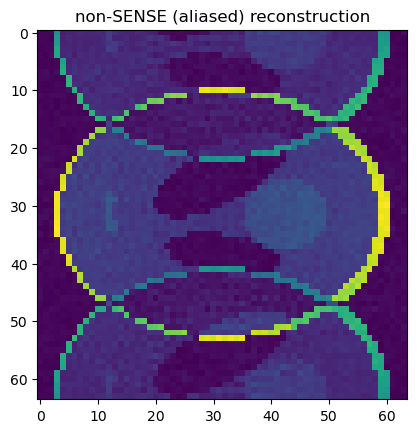

In [34]:
# create NUFFT objects, use 'ortho' for orthogonal FFTs
imx = image.unsqueeze(0).unsqueeze(0) # expand batch and coil dimensions
im_size = image.squeeze().shape
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
).to(imx)
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
).to(imx)

# define forward and adjoint operations
def A_fwd(x):
    x = x.clone().unsqueeze(0).unsqueeze(0)
    return nufft_ob(x,ktraj,smaps=smaps.unsqueeze(0))
def A_adj(b):
    return adjnufft_ob(b,ktraj,smaps=smaps.unsqueeze(0)).clone().squeeze()

# calculate k-space data as direct forward transform
kdata = A_fwd(image)

# add some noise (robustness test)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)

# plot recon w/ no SENSE, no density compensation
image_nonSENSE = A_adj(kdata)
plt.figure(0)
plt.imshow(np.absolute(image_nonSENSE.cpu().numpy()))
plt.title('non-SENSE (aliased) reconstruction')
plt.show()

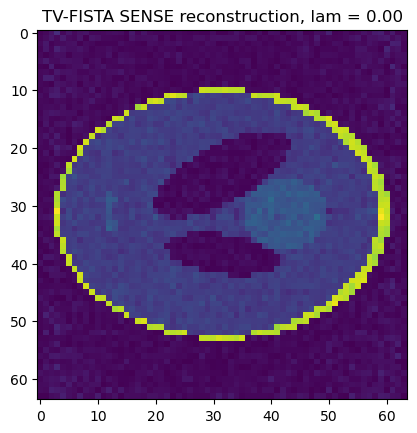

In [44]:
# calculate optimal lipschitz coefficient and recon
lam = 0
niter = 200
L = utils.opt.pwritr(A_fwd,A_adj,image_nonSENSE.squeeze())
image_tvfista, cost, x_set = tvdeblur(A_fwd, A_adj, kdata, lam=lam, niter=niter, L=L, chat=0)

# plot the image
plt.figure(0)
plt.imshow(np.absolute(image_tvfista.cpu().numpy()))
plt.title('TV-FISTA SENSE reconstruction, lam = %.2f' % lam)
plt.show()